## Credit Card Fraud Detection

Autora: Jéssica Ramos

Dataset: https://www.kaggle.com/mlg-ulb/creditcardfraud

### Problema

**Problema:** Classificar transações de cartão de crédito como de alto ou baixo risco de fraude.

**Proposta:** Criar um modelo de classificação que atribua uma probabilidade de fraude para cada transação. A partir dessa probabilidade, será definido um threshold que classificará a transação como "alto risco" ou "baixo risco".

### Entendendo a base

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

# leitura do dataset
data = pd.read_csv('./data/creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.00000,-1.35981,-0.07278,2.53635,1.37816,-0.33832,0.46239,0.23960,0.09870,0.36379,0.09079,-0.55160,-0.61780,-0.99139,-0.31117,1.46818,-0.47040,0.20797,0.02579,0.40399,0.25141,-0.01831,0.27784,-0.11047,0.06693,0.12854,-0.18911,0.13356,-0.02105,149.62000,0
1,0.00000,1.19186,0.26615,0.16648,0.44815,0.06002,-0.08236,-0.07880,0.08510,-0.25543,-0.16697,1.61273,1.06524,0.48910,-0.14377,0.63556,0.46392,-0.11480,-0.18336,-0.14578,-0.06908,-0.22578,-0.63867,0.10129,-0.33985,0.16717,0.12589,-0.00898,0.01472,2.69000,0
2,1.00000,-1.35835,-1.34016,1.77321,0.37978,-0.50320,1.80050,0.79146,0.24768,-1.51465,0.20764,0.62450,0.06608,0.71729,-0.16595,2.34586,-2.89008,1.10997,-0.12136,-2.26186,0.52498,0.24800,0.77168,0.90941,-0.68928,-0.32764,-0.13910,-0.05535,-0.05975,378.66000,0
3,1.00000,-0.96627,-0.18523,1.79299,-0.86329,-0.01031,1.24720,0.23761,0.37744,-1.38702,-0.05495,-0.22649,0.17823,0.50776,-0.28792,-0.63142,-1.05965,-0.68409,1.96578,-1.23262,-0.20804,-0.10830,0.00527,-0.19032,-1.17558,0.64738,-0.22193,0.06272,0.06146,123.50000,0
4,2.00000,-1.15823,0.87774,1.54872,0.40303,-0.40719,0.09592,0.59294,-0.27053,0.81774,0.75307,-0.82284,0.53820,1.34585,-1.11967,0.17512,-0.45145,-0.23703,-0.03819,0.80349,0.40854,-0.00943,0.79828,-0.13746,0.14127,-0.20601,0.50229,0.21942,0.21515,69.99000,0


**Colunas do dataset:**

- Time: Segundos entre a primeira transação do dataset e a transação em questão.
- V1 a V28: Componentes principais obtidos das variáveis originais.
- Amount: Valor da transação.
- Class: A classificação da transação, sendo 1 = fraude e 0 = não fraude.

In [3]:
# medidas descritivas
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000,284807.00000
mean,94813.85958,0.00000,0.00000,-0.00000,0.00000,-0.00000,0.00000,-0.00000,-0.00000,-0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,-0.00000,-0.00000,88.34962,0.00173
std,47488.14595,1.95870,1.65131,1.51626,1.41587,1.38025,1.33227,1.23709,1.19435,1.09863,1.08885,1.02071,0.99920,0.99527,0.95860,0.91532,0.87625,0.84934,0.83818,0.81404,0.77093,0.73452,0.72570,0.62446,0.60565,0.52128,0.48223,0.40363,0.33008,250.12011,0.04153
min,0.00000,-56.40751,-72.71573,-48.32559,-5.68317,-113.74331,-26.16051,-43.55724,-73.21672,-13.43407,-24.58826,-4.79747,-18.68371,-5.79188,-19.21433,-4.49894,-14.12985,-25.16280,-9.49875,-7.21353,-54.49772,-34.83038,-10.93314,-44.80774,-2.83663,-10.29540,-2.60455,-22.56568,-15.43008,0.00000,0.00000
25%,54201.50000,-0.92037,-0.59855,-0.89036,-0.84864,-0.69160,-0.76830,-0.55408,-0.20863,-0.64310,-0.53543,-0.76249,-0.40557,-0.64854,-0.42557,-0.58288,-0.46804,-0.48375,-0.49885,-0.45630,-0.21172,-0.22839,-0.54235,-0.16185,-0.35459,-0.31715,-0.32698,-0.07084,-0.05296,5.60000,0.00000
50%,84692.00000,0.01811,0.06549,0.17985,-0.01985,-0.05434,-0.27419,0.04010,0.02236,-0.05143,-0.09292,-0.03276,0.14003,-0.01357,0.05060,0.04807,0.06641,-0.06568,-0.00364,0.00373,-0.06248,-0.02945,0.00678,-0.01119,0.04098,0.01659,-0.05214,0.00134,0.01124,22.00000,0.00000
75%,139320.50000,1.31564,0.80372,1.02720,0.74334,0.61193,0.39856,0.57044,0.32735,0.59714,0.45392,0.73959,0.61824,0.66250,0.49315,0.64882,0.52330,0.39967,0.50081,0.45895,0.13304,0.18638,0.52855,0.14764,0.43953,0.35072,0.24095,0.09105,0.07828,77.16500,0.00000
max,172792.00000,2.45493,22.05773,9.38256,16.87534,34.80167,73.30163,120.58949,20.00721,15.59499,23.74514,12.01891,7.84839,7.12688,10.52677,8.87774,17.31511,9.25353,5.04107,5.59197,39.42090,27.20284,10.50309,22.52841,4.58455,7.51959,3.51735,31.61220,33.84781,25691.16000,1.00000


Todas as variáveis estão completas. 0.173% da base é composta de transações fraudulentas.

#### Distribuição das variáveis nos grupos

In [4]:
def boxplot(variable):
    sns.catplot(data = data, x = 'Class', y = variable, kind = 'box').set(title = variable)

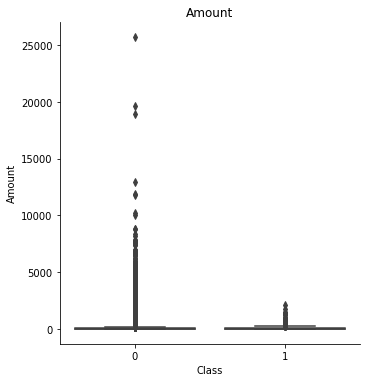

In [5]:
boxplot('Amount')

A variável `Amount` é bastante assimétrica à direita. Vou aplicar uma transformação de log para ser mais fácil visualizar a distribuição. Como existe o valor 0 em amount, vou também adicionar 1 unidade no valor da variável.

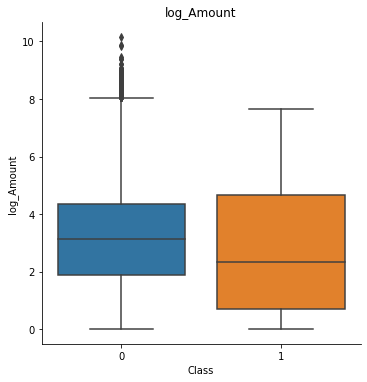

In [6]:
data['log_Amount'] = data['Amount'].apply(lambda x: math.log(x+1))

boxplot('log_Amount')

As transações fraudulentas têm valores mais dispersos do que as transações legítimas.

As demais variáveis não têm interpertação direta associada, mas vou plotar os boxplots para ter uma ideia de separação entre os grupos.

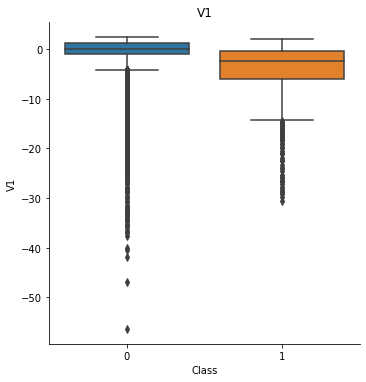

In [7]:
boxplot('V1')

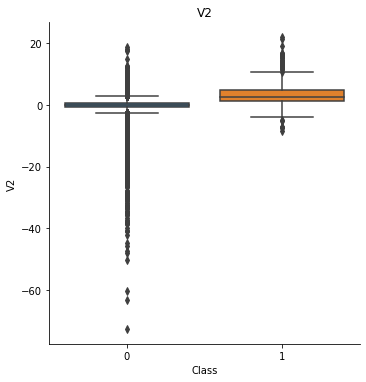

In [8]:
boxplot('V2')

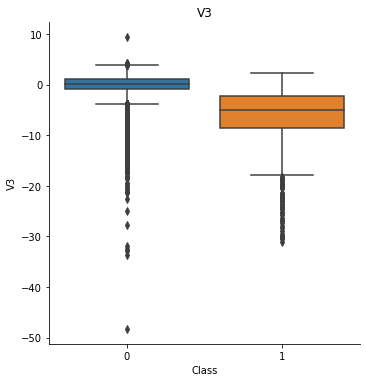

In [9]:
boxplot('V3')

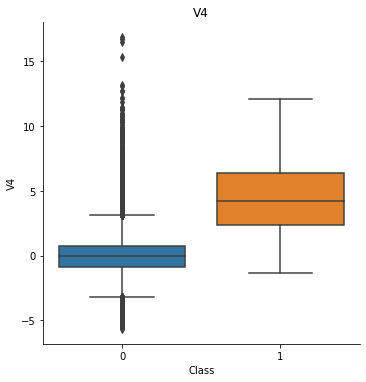

In [10]:
boxplot('V4')

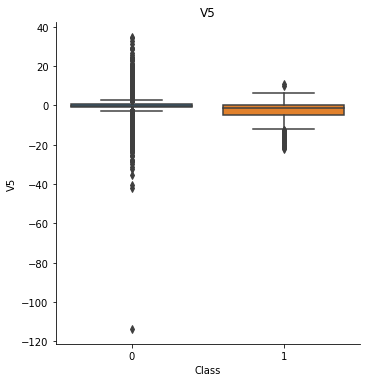

In [11]:
boxplot('V5')

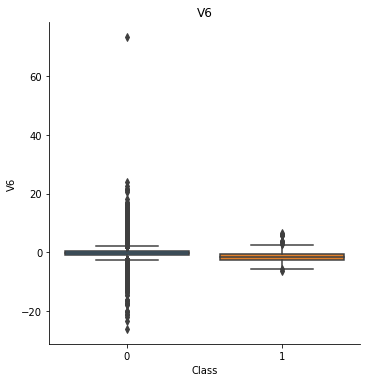

In [12]:
boxplot('V6')

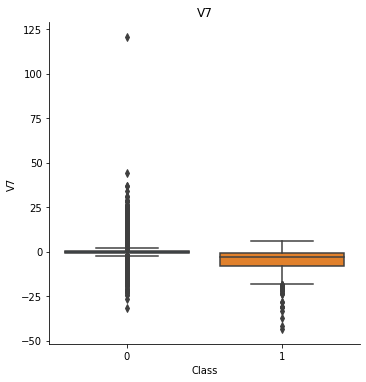

In [13]:
boxplot('V7')

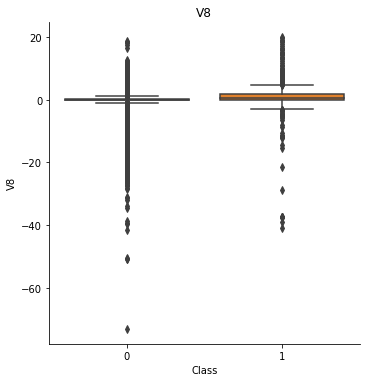

In [14]:
boxplot('V8')

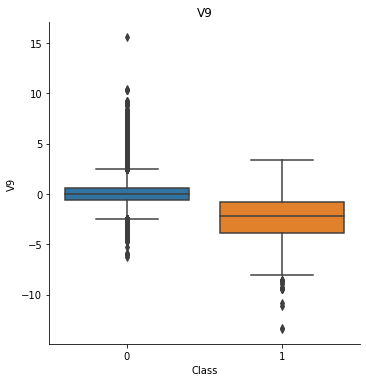

In [15]:
boxplot('V9')

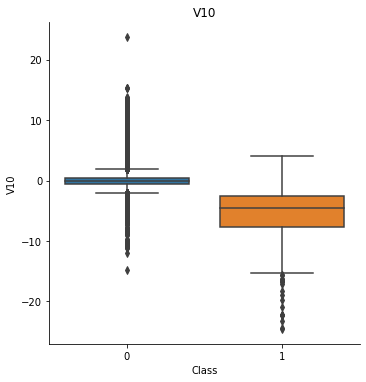

In [16]:
boxplot('V10')

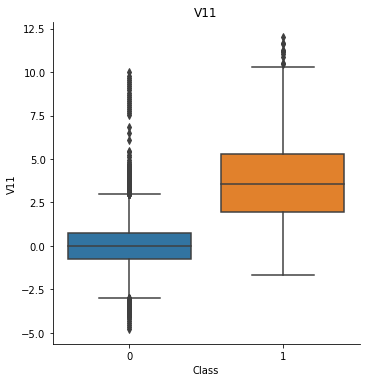

In [17]:
boxplot('V11')

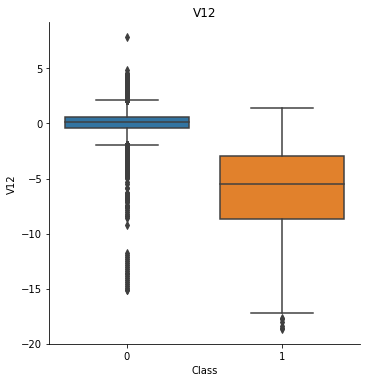

In [18]:
boxplot('V12')

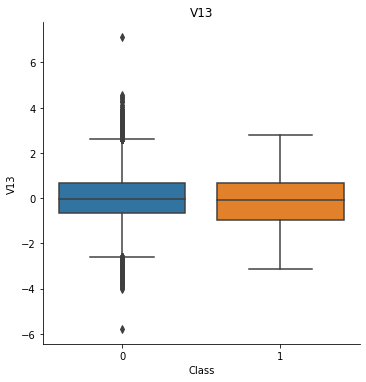

In [19]:
boxplot('V13')

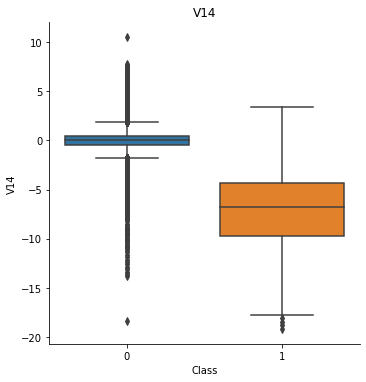

In [20]:
boxplot('V14')

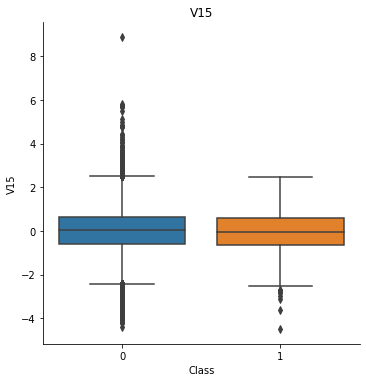

In [21]:
boxplot('V15')

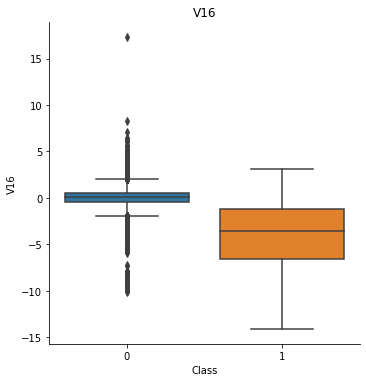

In [22]:
boxplot('V16')

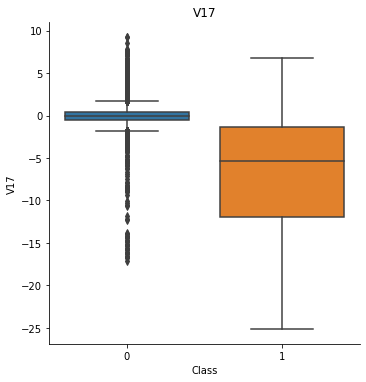

In [23]:
boxplot('V17')

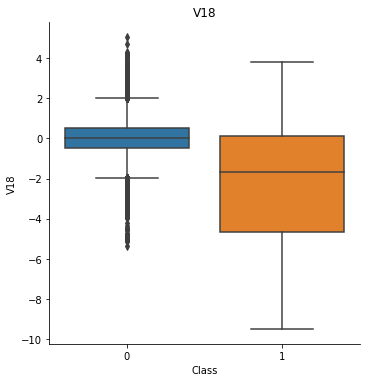

In [24]:
boxplot('V18')

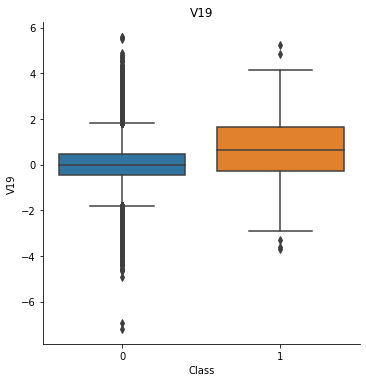

In [25]:
boxplot('V19')

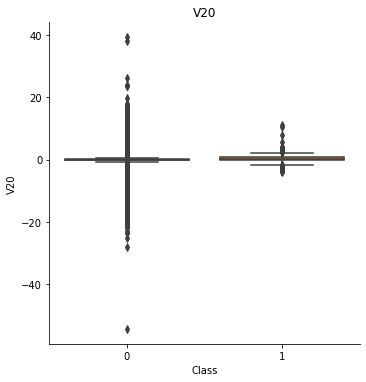

In [26]:
boxplot('V20')

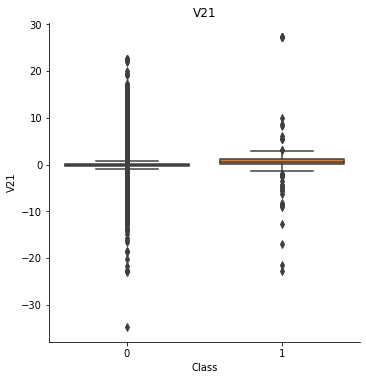

In [27]:
boxplot('V21')

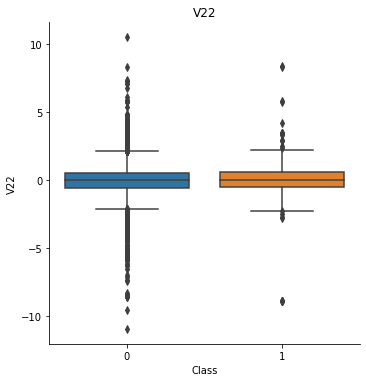

In [28]:
boxplot('V22')

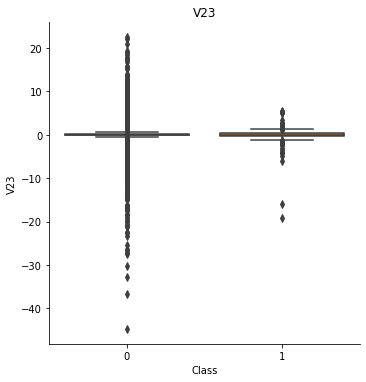

In [29]:
boxplot('V23')

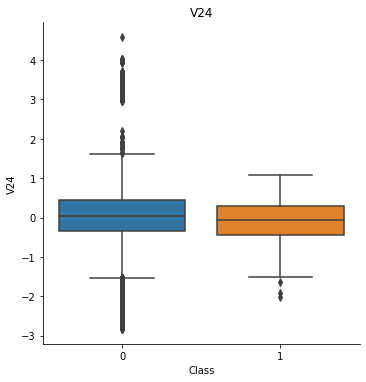

In [30]:
boxplot('V24')

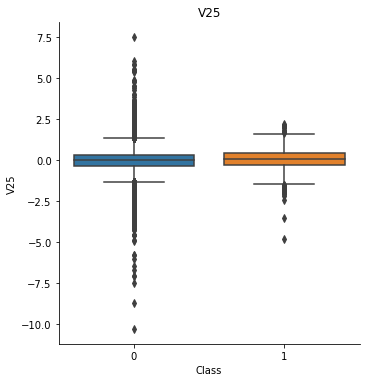

In [31]:
boxplot('V25')

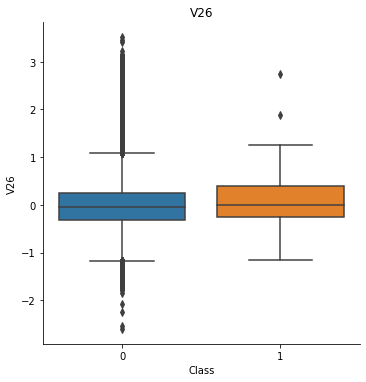

In [32]:
boxplot('V26')

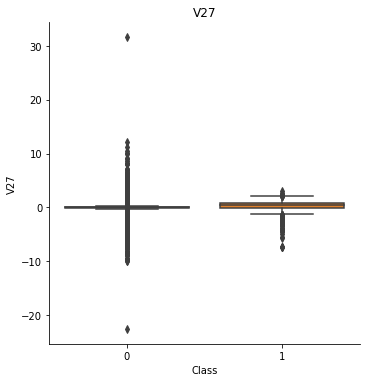

In [33]:
boxplot('V27')

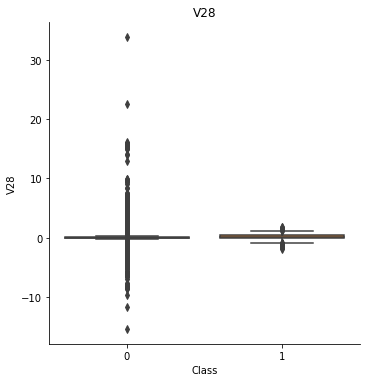

In [34]:
boxplot('V28')

Em muitas variáveis não existe clara separação das distribuições. Em geral, a classe de transações fraudulentas tem valores mais dispersos. Ambas as classes têm distribuições com muitos outliers.

Como as variáveis são resultado de PCA, não precisamos nos preocupar com colinearidades entre elas.

### Separação das bases de treino e teste

Vou dividir a base usando 70% para treino e 30% para teste. As transações da base de teste serão as últimas, usando a variável Time como referência.

In [35]:
# calcula o percentil
perc70 = data[['Time']].quantile(0.7)
perc70[0]

132929.0

In [36]:
# cria a base de treino
X_train = data[data['Time'] <= perc70[0]].copy()
X_train.drop(['Class','Time','Amount'], axis = 1, inplace = True)
y_train = data[data['Time'] <= perc70[0]]['Class'].copy()

# cria a base de teste
X_test = data[data['Time'] > perc70[0]].copy()
X_test.drop(['Class','Time','Amount'], axis = 1, inplace = True)
y_test = data[data['Time'] > perc70[0]]['Class'].copy()

In [37]:
# preditores treino
X_train.shape

(199368, 29)

In [38]:
# preditores teste
X_test.shape

(85439, 29)

In [39]:
# distribução do target na base de treino
y_train.describe()

count   199368.00000
mean         0.00193
std          0.04385
min          0.00000
25%          0.00000
50%          0.00000
75%          0.00000
max          1.00000
Name: Class, dtype: float64

In [40]:
# distribução do target na base de teste
y_test.describe()

count   85439.00000
mean        0.00126
std         0.03553
min         0.00000
25%         0.00000
50%         0.00000
75%         0.00000
max         1.00000
Name: Class, dtype: float64

A base de treino tem 199.368 observações, sendo 0.193% fraudes. A base de teste tem 85.439 observações, sendo 0.126% fraudes.

### Corrigindo o desbalanceamento

A base de treino é muito desbalanceada, o que pode fazer os resultados não serem muito bons para a classe positiva. Para corrigir o desbalanceamento, vou aplicar SMOTE apenas na classe positiva.

In [41]:
from imblearn.over_sampling import SMOTE

oversample = SMOTE(sampling_strategy = 'minority') # apenas afeta a classe positiva
X_train_new, y_train_new = oversample.fit_resample(X_train, y_train)

In [42]:
# resultado
size = y_train_new.shape[0]
prop = y_train_new.mean()

print('Observations: ', size, '\nProportion of fraud: ', prop)

Observations:  397968 
Proportion of fraud:  0.5


A nova base gerada tem 397.968 observações, sendo 50% transações fraudulentas.

### Modelo Logístico

Primeiro, vou ajustar um modelo logístico tradicional. As métricas de referência serão recall, specificity (recall da categoria negativa) e precision.

Escolhi o recall como métrica principal pensando num problema de fraudes em que transações com alto risco de fraude passariam por uma segunda autenticação. Portanto, é importante que as transações de fato fraudulentas tenham risco alto, ainda que existam vários falsos positivos.

In [43]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression

In [44]:
# fit do modelo logístico
lr = LogisticRegression()
lr.fit(X_train_new, y_train_new)

# predições
y_pred_train_lr = lr.predict(X_train_new)
y_pred_test_lr = lr.predict(X_test)

In [45]:
# métricas de treino
metric_train_lr = precision_recall_fscore_support(y_train_new, y_pred_train_lr)

print('Precision: ', metric_train_lr[0][1],
      '\nRecall: ', metric_train_lr[1][1],
      '\nSpecificity: ', metric_train_lr[1][0])

Precision:  0.9770029202640934 
Recall:  0.9280997467133035 
Specificity:  0.9781540224339645


In [46]:
# métricas de teste
metric_test_lr = precision_recall_fscore_support(y_test, y_pred_test_lr)

print('Precision: ', metric_test_lr[0][1],
      '\nRecall: ', metric_test_lr[1][1],
      '\nSpecificity: ', metric_test_lr[1][0])

Precision:  0.042525208241999124 
Recall:  0.8981481481481481 
Specificity:  0.974405550151762


In [47]:
# observações classificadas como positivas
y_pred_test_lr.mean()

0.026697409847961703

In [49]:
# salva o modelo
import pickle
pickle.dump(lr, open('./models/logistic_regression.sav', 'wb'))

O modelo logístico acertou 89.8% das observações fraudulentas e 97.4% das não fraudulentas na base de teste. Dentre as 2.7% de observações classificadas como fraude, 4.3% são de fato fraudes.

O modelo por default já considera regularização L2. Posso tentar otimizar o parâmetro usando cross validation.

In [50]:
from sklearn.model_selection import GridSearchCV

# define valores de C para testar
params_l2 = {'C': [10.0, 5.0, 2.0, 1.5, 1.0, 0.8, 0.5, 0.1, 0.01, 0.001]} # quanto menor, maior o peso do termo L2

l2_grid = GridSearchCV(estimator = LogisticRegression(),
                       param_grid = params_l2,
                       scoring = 'recall',
                       cv = 5,
                       verbose = 1)

# ajusta
l2_grid.fit(X_train_new, y_train_new)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [10.0, 5.0, 2.0, 1.5, 1.0, 0.8, 0.5, 0.1, 0.01,
                               0.001]},
             scoring='recall', verbose=1)

In [51]:
# resultado
pd.DataFrame(l2_grid.cv_results_).head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.58385,0.39799,0.05247,0.01460,10.0,{'C': 10.0},0.93140,0.92781,0.92819,0.92655,0.92816,0.92842,0.00161,1
1,3.73296,1.16625,0.04150,0.01277,5.0,{'C': 5.0},0.93140,0.92781,0.92819,0.92655,0.92816,0.92842,0.00161,1
2,4.62928,0.81383,0.05021,0.01267,2.0,{'C': 2.0},0.93138,0.92781,0.92819,0.92655,0.92814,0.92841,0.00160,3
3,3.41664,0.55282,0.04130,0.01256,1.5,{'C': 1.5},0.93138,0.92781,0.92816,0.92655,0.92814,0.92841,0.00160,4
4,3.53573,0.68952,0.04609,0.01013,1.0,{'C': 1.0},0.93130,0.92778,0.92816,0.92655,0.92814,0.92839,0.00157,5
5,3.68003,0.62084,0.04150,0.01273,0.8,{'C': 0.8},0.93128,0.92778,0.92816,0.92655,0.92814,0.92838,0.00156,6
6,3.81827,0.57154,0.04442,0.01606,0.5,{'C': 0.5},0.93123,0.92776,0.92816,0.92655,0.92814,0.92837,0.00155,7
7,3.51834,0.63153,0.04827,0.01161,0.1,{'C': 0.1},0.93097,0.92771,0.92798,0.92642,0.92809,0.92824,0.00149,8
8,3.45495,0.74178,0.04688,0.01103,0.01,{'C': 0.01},0.92927,0.92633,0.92655,0.92509,0.92655,0.92676,0.00137,9
9,2.43650,0.54427,0.04089,0.01223,0.001,{'C': 0.001},0.92263,0.91932,0.92072,0.91924,0.92097,0.92058,0.00125,10


A variação entre os resultados é de fato bem pequena. Portanto vou manter o modelo default que já ajustamos como o melhor resultado para a regressão logística.

### Random Forest

O modelo linear teve resultados bons, mas vou tentar melhorar o resultado com uma Random Forest. Existem vários parâmetros que podem ser otimizados, portanto vou usar uma grid search para encontrar o melhor parâmetro. O tempo de processamento para esse algortimo é maior, então não usarei cross validation, mas sim uma base de validação. Os valores na lista de busca são bem arbitrários, fui alterando à medida que rodei alguns resultados.

In [52]:
from sklearn.model_selection import RandomizedSearchCV, PredefinedSplit
from sklearn.ensemble import RandomForestClassifier
import random

# define o set de validação como 20% da base de treino de forma aleatória
my_test_fold = [0] * X_train_new.shape[0]

for i in range(X_train_new.shape[0]):
    p = random.random()
    if p > 0.2:
        my_test_fold[i] = -1 # treino
        
print('% of train set: ', -sum(my_test_fold)/X_train_new.shape[0])

% of train set:  0.800393498974792


In [53]:
# define a grid de hiperparâmetos
params_rf = {'n_estimators': [100, 200, 300, 400, 500, 600], # número de árvores
             'max_depth': [3, 4, 5, 6, 7, 8], # profundidade máxima de cada arvore
             'min_samples_leaf': [5, 6, 7, 10, 15, 20], # mínimo de amostras por folha
             'max_features': [0.7, 0.8, 0.9, 1.0]} # proporção das features consideradas em cada split

# define os termos do grid search
rf_grid = RandomizedSearchCV(estimator = RandomForestClassifier(),
                             param_distributions = params_rf,
                             scoring = 'recall',
                             n_jobs = -1,
                             n_iter = 10,
                             cv = list(PredefinedSplit(test_fold = my_test_fold).split(X_train_new, y_train_new)),
                             random_state = 10,
                             verbose = 2)

# ajusta
rf_grid.fit(X_train_new, y_train_new)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 397963, 397965, 397967]),
                        array([     3,      5,     21, ..., 397960, 397964, 397966]))],
                   estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [3, 4, 5, 6, 7, 8],
                                        'max_features': [0.7, 0.8, 0.9, 1.0],
                                        'min_samples_leaf': [5, 6, 7, 10, 15,
                                                             20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   random_state=10, scoring='recall', verbose=2)

In [54]:
# resultado
pd.DataFrame(rf_grid.cv_results_).sort_values(by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_features,param_max_depth,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
2,4958.63224,0.00000,4.68764,0.00000,300,15,0.8,8,"{'n_estimators': 300, 'min_samples_leaf': 15, ...",0.98284,0.98284,0.00000,1
6,7371.30885,0.00000,3.94840,0.00000,500,7,0.9,8,"{'n_estimators': 500, 'min_samples_leaf': 7, '...",0.98252,0.98252,0.00000,2
1,6500.18949,0.00000,5.68180,0.00000,500,5,0.7,8,"{'n_estimators': 500, 'min_samples_leaf': 5, '...",0.98206,0.98206,0.00000,3
8,2927.96556,0.00000,3.30382,0.00000,200,15,0.7,8,"{'n_estimators': 200, 'min_samples_leaf': 15, ...",0.98105,0.98105,0.00000,4
5,5715.10090,0.00000,4.58898,0.00000,400,5,0.8,7,"{'n_estimators': 400, 'min_samples_leaf': 5, '...",0.97390,0.97390,0.00000,5


In [55]:
# melhor modelo
rf = rf_grid.best_estimator_

# predições
y_pred_train_rf = rf.predict(X_train_new)
y_pred_test_rf = rf.predict(X_test)

In [56]:
# métricas de treino
metric_train_rf = precision_recall_fscore_support(y_train_new, y_pred_train_rf)

print('Precision: ', metric_train_rf[0][1],
      '\nRecall: ', metric_train_rf[1][1],
      '\nSpecificity: ', metric_train_rf[1][0])

Precision:  0.994252698490064 
Recall:  0.984149479355124 
Specificity:  0.994311100389981


In [57]:
# métricas de teste
metric_test_rf = precision_recall_fscore_support(y_test, y_pred_test_rf)

print('Precision: ', metric_test_rf[0][1],
      '\nRecall: ', metric_test_rf[1][1],
      '\nSpecificity: ', metric_test_rf[1][0])

Precision:  0.18791946308724833 
Recall:  0.7777777777777778 
Specificity:  0.9957459774290703


In [58]:
# observações classificadas como positivas
y_pred_test_rf.mean()

0.00523180280668079

In [59]:
# salva o modelo
pickle.dump(rf, open('./models/random_forest.sav', 'wb'))

A specificity ficou mais alta do que o modelo logístico, porém o recall ficou menor. Talvez se ajustarmos o threshold na base de teste teremos um resultado melhor.

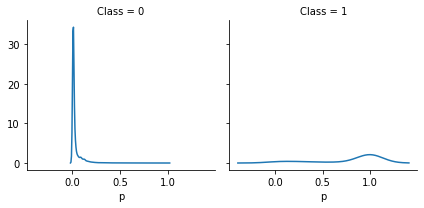

In [60]:
# visualiza a distribuição
p_pred_test_rf = rf.predict_proba(X_test)
result_rf = pd.DataFrame({'Class': y_test, 'p': p_pred_test_rf[:,1]})

g = sns.FacetGrid(result_rf, col = 'Class')
g.map(sns.kdeplot, 'p')

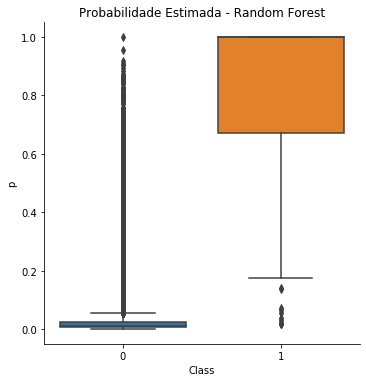

In [61]:
sns.catplot(data = result_rf, x = 'Class', y = 'p', kind = 'box').set(title = 'Probabilidade Estimada - Random Forest')

A distribuição da probabilidade estimada para a classe 0 é bastante concentrada perto de 0 e tem muitos outliers, enquanto para a classe 0 é mais dispersa. Vou testar alguns valores diferentes de threshold menores do que 0,5 e avaliar a diferença.

In [62]:
thresholds = [0.45, 0.4, 0.35, 0.3, 0.25, 0.2]

# resultado de teste
for t in thresholds:
    
    # cria o resultado binário
    string = 'p > ' + str(t)
    result_rf[string] = result_rf['p'].apply(lambda x: 1 if x > t else 0)
    
    # calcula as métricas
    metric = precision_recall_fscore_support(y_test, result_rf[string])
    
    # imprime o resultado
    print('\n')
    print('Resultado para ' + string)
    print('Precision: ', metric[0][1],
          '\nRecall: ', metric[1][1],
          '\nSpecificity: ', metric[1][0])



Resultado para p > 0.45
Precision:  0.1579925650557621 
Recall:  0.7870370370370371 
Specificity:  0.9946912610891704


Resultado para p > 0.4
Precision:  0.12912912912912913 
Recall:  0.7962962962962963 
Specificity:  0.9932029391428672


Resultado para p > 0.35
Precision:  0.10114942528735632 
Recall:  0.8148148148148148 
Specificity:  0.990835686913314


Resultado para p > 0.3
Precision:  0.0782608695652174 
Recall:  0.8333333333333334 
Specificity:  0.9875777853300676


Resultado para p > 0.25
Precision:  0.060407091267235716 
Recall:  0.8518518518518519 
Specificity:  0.9832300101955913


Resultado para p > 0.2
Precision:  0.042505592841163314 
Recall:  0.8796296296296297 
Specificity:  0.9749211892512686


In [63]:
# observações classificadas como positivas
result_rf['p > 0.2'].mean()

0.026159014033403948

Com o threshold igual a 0,2 a specificity é similar à do modelo logístico com corte 0,5 porém o recall é mais baixo. Além disso, a precision também é menor. Dessa forma, o modelo logístico parece ter um desempenho superior.

In [64]:
# resultado de treino pro melhor cenário
p_pred_train_rf = rf.predict_proba(X_train_new)
result_rf_train = pd.DataFrame({'p': p_pred_train_rf[:,1]})
result_rf_train['p > 0.2'] = result_rf_train['p'].apply(lambda x: 1 if x > 0.2 else 0)
metric = precision_recall_fscore_support(y_train_new, result_rf_train['p > 0.2'])

# imprime o resultado
print('Resultado para p > 0.2')
print('Precision: ', metric[0][1],
      '\nRecall: ', metric[1][1],
      '\nSpecificity: ', metric[1][0])

Resultado para p > 0.2
Precision:  0.9717210253586493 
Recall:  0.9932959433924335 
Specificity:  0.9710931532183492


### Gradient Boosting

Vou avaliar também um Gradient Boosting. Também faço aqui a busca por hiperparâmetros ótimos.

In [66]:
from sklearn.ensemble import GradientBoostingClassifier

# define a grid de hiperparâmetos
params_gb = {'learning_rate': [0.1, 0.05, 0.01, 0.001], # taxa de aprendizado
             'n_estimators': [100, 200, 300, 400, 500, 600], # número de árvores
             'max_depth': [3, 4, 5, 6, 7, 8], # profundidade máxima de cada arvore
             'min_samples_leaf': [5, 6, 7, 10, 15, 20], # mínimo de amostras por folha
             'max_features': [0.7, 0.8, 0.9, 1.0]} # proporção das features consideradas em cada split

gb_grid = RandomizedSearchCV(estimator = GradientBoostingClassifier(),
                             param_distributions = params_gb,
                             scoring = 'recall',
                             n_jobs = -1,
                             n_iter = 10,
                             cv = list(PredefinedSplit(test_fold = my_test_fold).split(X_train_new, y_train_new)),
                             random_state = 10,
                             verbose = 2)

# ajusta
gb_grid.fit(X_train_new, y_train_new)

Fitting 1 folds for each of 10 candidates, totalling 10 fits


RandomizedSearchCV(cv=[(array([     0,      1,      2, ..., 397963, 397965, 397967]),
                        array([     3,      5,     21, ..., 397960, 397964, 397966]))],
                   estimator=GradientBoostingClassifier(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.1, 0.05, 0.01,
                                                          0.001],
                                        'max_depth': [3, 4, 5, 6, 7, 8],
                                        'max_features': [0.7, 0.8, 0.9, 1.0],
                                        'min_samples_leaf': [5, 6, 7, 10, 15,
                                                             20],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600]},
                   random_state=10, scoring='recall', verbose=2)

In [67]:
# resultado
pd.DataFrame(gb_grid.cv_results_).sort_values(by = 'rank_test_score').head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_leaf,param_max_features,param_max_depth,param_learning_rate,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
9,5621.14251,0.00000,1.48857,0.00000,300,6,0.9,7,0.05,"{'n_estimators': 300, 'min_samples_leaf': 6, '...",0.99997,0.99997,0.00000,1
0,11035.68696,0.00000,2.09930,0.00000,600,15,1.0,5,0.05,"{'n_estimators': 600, 'min_samples_leaf': 15, ...",0.99992,0.99992,0.00000,2
2,11479.25014,0.00000,1.23573,0.00000,600,10,0.9,6,0.1,"{'n_estimators': 600, 'min_samples_leaf': 10, ...",0.99992,0.99992,0.00000,2
6,6942.64384,0.00000,2.51027,0.00000,500,15,0.7,5,0.05,"{'n_estimators': 500, 'min_samples_leaf': 15, ...",0.99992,0.99992,0.00000,2
8,4340.55642,0.00000,1.60341,0.00000,200,7,0.7,8,0.1,"{'n_estimators': 200, 'min_samples_leaf': 7, '...",0.99990,0.99990,0.00000,5


In [68]:
# melhor modelo
gb = gb_grid.best_estimator_

# predições
y_pred_train_gb = rf.predict(X_train_new)
y_pred_test_gb = rf.predict(X_test)

In [69]:
# métricas de treino
metric_train_gb = precision_recall_fscore_support(y_train_new, y_pred_train_gb)

print('Precision: ', metric_train_gb[0][1],
      '\nRecall: ', metric_train_gb[1][1],
      '\nSpecificity: ', metric_train_gb[1][0])

Precision:  0.994252698490064 
Recall:  0.984149479355124 
Specificity:  0.994311100389981


In [70]:
# métricas de teste
metric_test_gb = precision_recall_fscore_support(y_test, y_pred_test_gb)

print('Precision: ', metric_test_gb[0][1],
      '\nRecall: ', metric_test_gb[1][1],
      '\nSpecificity: ', metric_test_gb[1][0])

Precision:  0.18791946308724833 
Recall:  0.7777777777777778 
Specificity:  0.9957459774290703


In [71]:
# observações classificadas como positivas
y_pred_test_gb.mean()

0.00523180280668079

Como o modelo random forest, a especificidade com o threshold 0.5 é bem alta, sacrificando o recall. Vale aqui também verificar a distribuição e testar outros thresholds.

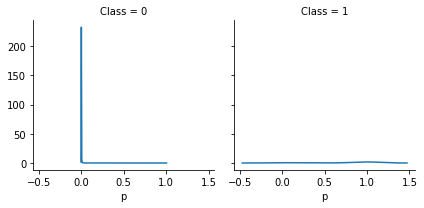

In [72]:
# visualiza a distribuição
p_pred_test_gb = gb.predict_proba(X_test)
result_gb = pd.DataFrame({'Class': y_test, 'p': p_pred_test_gb[:,1]})

g = sns.FacetGrid(result_gb, col = 'Class')
g.map(sns.kdeplot, 'p')

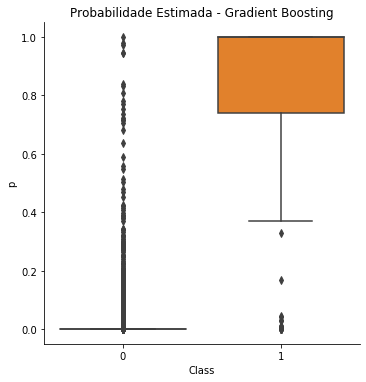

In [73]:
sns.catplot(data = result_gb, x = 'Class', y = 'p', kind = 'box').set(title = 'Probabilidade Estimada - Gradient Boosting')

A distribuição da probabilidade para a classe 0 é bastante concentrada próximo de 0, ou seja, podemos baixar o threshold bastante sem perder tanta specificity.

In [83]:
thresholds = [0.25, 0.2, 0.15, 0.10, 0.05, 0.03, 0.01, 0.005, 0.004, 0.003, 0.001]

# resultado de teste
for t in thresholds:
    
    # cria o resultado binário
    string = 'p > ' + str(t)
    result_gb[string] = result_gb['p'].apply(lambda x: 1 if x > t else 0)
    
    # calcula as métricas
    metric = precision_recall_fscore_support(y_test, result_gb[string])
    
    # imprime o resultado
    print('\n')
    print('Resultado para ' + string)
    print('Precision: ', metric[0][1],
          '\nRecall: ', metric[1][1],
          '\nSpecificity: ', metric[1][0])



Resultado para p > 0.25
Precision:  0.581081081081081 
Recall:  0.7962962962962963 
Specificity:  0.9992734176325134


Resultado para p > 0.2
Precision:  0.5212121212121212 
Recall:  0.7962962962962963 
Specificity:  0.9990741934349767


Resultado para p > 0.15
Precision:  0.45549738219895286 
Recall:  0.8055555555555556 
Specificity:  0.9987812166738934


Resultado para p > 0.1
Precision:  0.36401673640167365 
Recall:  0.8055555555555556 
Specificity:  0.9982187012926135


Resultado para p > 0.05
Precision:  0.2536443148688047 
Recall:  0.8055555555555556 
Specificity:  0.9969999179665069


Resultado para p > 0.03
Precision:  0.18518518518518517 
Recall:  0.8333333333333334 
Specificity:  0.9953592481044403


Resultado para p > 0.01
Precision:  0.08139534883720931 
Recall:  0.8425925925925926 
Specificity:  0.9879645146546976


Resultado para p > 0.005
Precision:  0.04867944070429829 
Recall:  0.8703703703703703 
Specificity:  0.9784720675955983


Resultado para p > 0.004
Precision:

A partir de um threshold menor que 0,005 perdemos mais specificity do que ganhamos de recall.

In [86]:
# observações classificadas como positivas
result_gb['p > 0.005'].mean()

0.022600919954587483

Com esse threshold, 2,2% das observações seriam classificadas como fraudulentas, sendo que 4,9% delas de fato seriam fraudes. O recall na base de teste é 87,0% e a specificity é 97,8%.

Entendo que o modelo logístico, além de ser mais simples, apresentou resultados melhores do que o gradient boosting.

In [87]:
# resultado de treino pro melhor cenário
p_pred_train_gb = gb.predict_proba(X_train_new)
result_gb_train = pd.DataFrame({'p': p_pred_train_gb[:,1]})
result_gb_train['p > 0.005'] = result_gb_train['p'].apply(lambda x: 1 if x > 0.005 else 0)
metric = precision_recall_fscore_support(y_train_new, result_gb_train['p > 0.005'])

# imprime o resultado
print('Resultado para p > 0.005')
print('Precision: ', metric[0][1],
      '\nRecall: ', metric[1][1],
      '\nSpecificity: ', metric[1][0])

Resultado para p > 0.005
Precision:  0.9771265259622278 
Recall:  1.0 
Specificity:  0.9765910827001166


In [77]:
# salva o modelo
pickle.dump(gb, open('./models/gradient_boosting.sav', 'wb'))

### Resultado Final

Dos três algoritmos explorados, o modelo logístico foi o que apresentou melhor resultado em termos de recall e specificity, utilizando um threshold 0,5. Além disso, é um modelo mais simples do que os demais testados. Portanto, considero esse o melhor modelo.

Antes de finalizar, vou analisar outros possíveis thresholds para o modelo logístico.

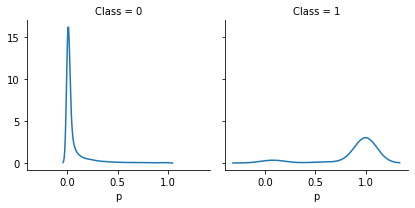

In [88]:
# visualiza a distribuição
p_pred_test_lr = lr.predict_proba(X_test)
result_lr = pd.DataFrame({'Class': y_test, 'p': p_pred_test_lr[:,1]})

g = sns.FacetGrid(result_lr, col = 'Class')
g.map(sns.kdeplot, 'p')

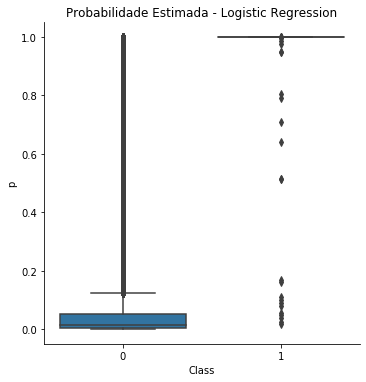

In [89]:
sns.catplot(data = result_lr, x = 'Class', y = 'p', kind = 'box').set(title = 'Probabilidade Estimada - Logistic Regression')

Olhando para a distribuição podemos ver que de fato a separação é muito mais clara.

In [91]:
thresholds = [0.8, 0.75, 0.7, 0.65, 0.6, 0.55, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2]

# resultado de teste
for t in thresholds:
    
    # cria o resultado binário
    string = 'p > ' + str(t)
    result_lr[string] = result_lr['p'].apply(lambda x: 1 if x > t else 0)
    
    # calcula as métricas
    metric = precision_recall_fscore_support(y_test, result_lr[string])
    
    # imprime o resultado
    print('\n')
    print('Resultado para ' + string)
    print('Precision: ', metric[0][1],
          '\nRecall: ', metric[1][1],
          '\nSpecificity: ', metric[1][0])



Resultado para p > 0.8
Precision:  0.11557788944723618 
Recall:  0.8518518518518519 
Specificity:  0.9917497744078939


Resultado para p > 0.75
Precision:  0.09384460141271443 
Recall:  0.8611111111111112 
Specificity:  0.9894762747418875


Resultado para p > 0.7
Precision:  0.0785296574770259 
Recall:  0.8703703703703703 
Specificity:  0.9870738653010043


Resultado para p > 0.65
Precision:  0.06685633001422475 
Recall:  0.8703703703703703 
Specificity:  0.9846245795783478


Resultado para p > 0.6
Precision:  0.05743651753325272 
Recall:  0.8796296296296297 
Specificity:  0.9817299691788447


Resultado para p > 0.55
Precision:  0.0490702479338843 
Recall:  0.8796296296296297 
Specificity:  0.978425191313825


Resultado para p > 0.5
Precision:  0.042525208241999124 
Recall:  0.8981481481481481 
Specificity:  0.974405550151762


Resultado para p > 0.45
Precision:  0.035362741523878964 
Recall:  0.8981481481481481 
Specificity:  0.9689913396069424


Resultado para p > 0.4
Precision:  0

De fato, o threshold 0,5 é o que temos um recall alto sem perder muita specificity. Portanto, esse será considerado o melhor resultado.

### Interpretação do modelo final

Das variáveis utilizadas como preditoras, apenas a variável 'Amount' é interpretável. Porém, podemos ver a direção e força da relação linear estabelecida no modelo logístico com base nos betas estimados.

In [101]:
pd.DataFrame({'Feature': list(X_train_new.columns),
              'Beta': lr.coef_[0]})

,Feature,Beta
0,V1,0.26375
1,V2,-0.21766
2,V3,0.24173
3,V4,1.15197
4,V5,-0.11251
5,V6,-0.52966
6,V7,0.21717
7,V8,-0.60883
8,V9,-0.58345
9,V10,-1.12139


O log do valor da transação tem um beta negativo, ou seja, quanto maior o valor da transação, maior o risco de fraude.

As variáveis de maior peso no modelo são V4 (Beta = 1.15197), V10 (Beta = -1.12139), V14 (Beta = -1.03380) e V12 (Beta = -0.98508). Nessas quatro variáveis foi possível ver maior separação na análise inicial dos boxplots.

### Conclusões

Nesse notebook foi tratado um problema de identificação de fraudes entre transações de cartão de crédito. A solução proposta foi o ajuste de um modelo de classificação que atribuísse uma probabilidade de fraude p a cada transação, sendo que quanto maior o p, maior o risco de ser uma transação fraudulenta.

Foram testados e otimizados três algoritmos diferentes: logistic regression, random forst classifier e gradient boosting classifier. Dentre estres, o modelo logístico com regularização L2 (lambda = 1) apresentou o melhor resultado de separação entre as classes. Na base de teste e com um threshold de 0,5 em que transações com *p > 0,5* seriam consideradas de alto risco e as demais de baixo risco, **89,8% das transações fradulentas foram classificadas como de alto risco e 97.4% das transações legítimas foram classificadas como baixo risco**.

Vale destacar que a categoria de transações fraudulentas é bastante subrepresentada em relação às transações legítimas. Portanto, das transações de alto risco, apenas 4,3% são de fato fraudes. Seria recomendado utilizar essa definição de threshold num processo em que as transações de alto risco passam por uma segunda validação mais detalhada (auto-autenticação ou análise humana, por exemplo). Caso o objetivo seja rejeitar automaticamente transações de alto risco, recomendaria um threshold maior, que garantisse maior precisão.

Por último, o modelo gera um *p* que é uma probabilidade estimada de fraude. Esse valor pode ser transformado em uma distribuição mais fácil de trabalhar, pode ser utilizado em conjunto com outras regras de negócio para decisão, para o cálculo de perdas esperadas, entre outros. O resultado do modelo é de fato o *p* e seu uso pode ser adaptado.